In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import math
import matplotlib
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread
from glob import glob
from scipy.stats import mode
from collections import Counter
import math
import skimage
import re
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from tifffile import imread
from stardist.models import StarDist2D
from csbdeep.utils import normalize

sys.path.append("./")
import analysis as an
from importlib import reload

2023-08-02 08:19:28.677845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 08:19:36.707239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cstansbu/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-02 08:19:36.707264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-02 08:19:37.433505: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has

In [2]:
img_dir = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/data/BAB_vs_MAN/"

imgs = {}

for f in os.listdir(img_dir):
    label = f.split(".")[0]
    fullPath = f"{img_dir}{f}"
    img = skimage.io.imread(fullPath, as_gray=True)
    imgs[label] = img
    print(f"{label} {img.shape=}")

print('done')

BAB_3 img.shape=(1130, 1247)
BAB_2 img.shape=(1130, 1247)
BAB_1 img.shape=(1130, 1247)
Man_3 img.shape=(1227, 1183)
Man_2 img.shape=(1227, 1183)
Man_1 img.shape=(1227, 1183)
done


# segmentation

In [3]:
p = 0.5 # probability for segementation, high is more strict
model = StarDist2D.from_pretrained('2D_versatile_fluo')

segments = {}

for i, (label, image) in enumerate(imgs.items()):
    print(label, image.shape)

    nucLabels, data = model.predict_instances(normalize(image), prob_thresh=p)
    segments[label] = nucLabels

print('done')

Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-08-02 08:20:02.694941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cstansbu/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-08-02 08:20:02.726297: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-02 08:20:02.726332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3082.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2023-08-02 08:20:02.727626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
BAB_3 (1130, 1247)
1/1 [==============================] - 8s 8s/step
BAB_2 (1130, 1247)
1/1 [==============================] - 5s 5s/step
BAB_1 (1130, 1247)
1/1 [==============================] - 5s 5s/step
Man_3 (1227, 1183)
1/1 [==============================] - 5s 5s/step
Man_2 (1227, 1183)
1/1 [==============================] - 5s 5s/step
Man_1 (1227, 1183)
1/1 [==============================] - 5s 5s/step
done


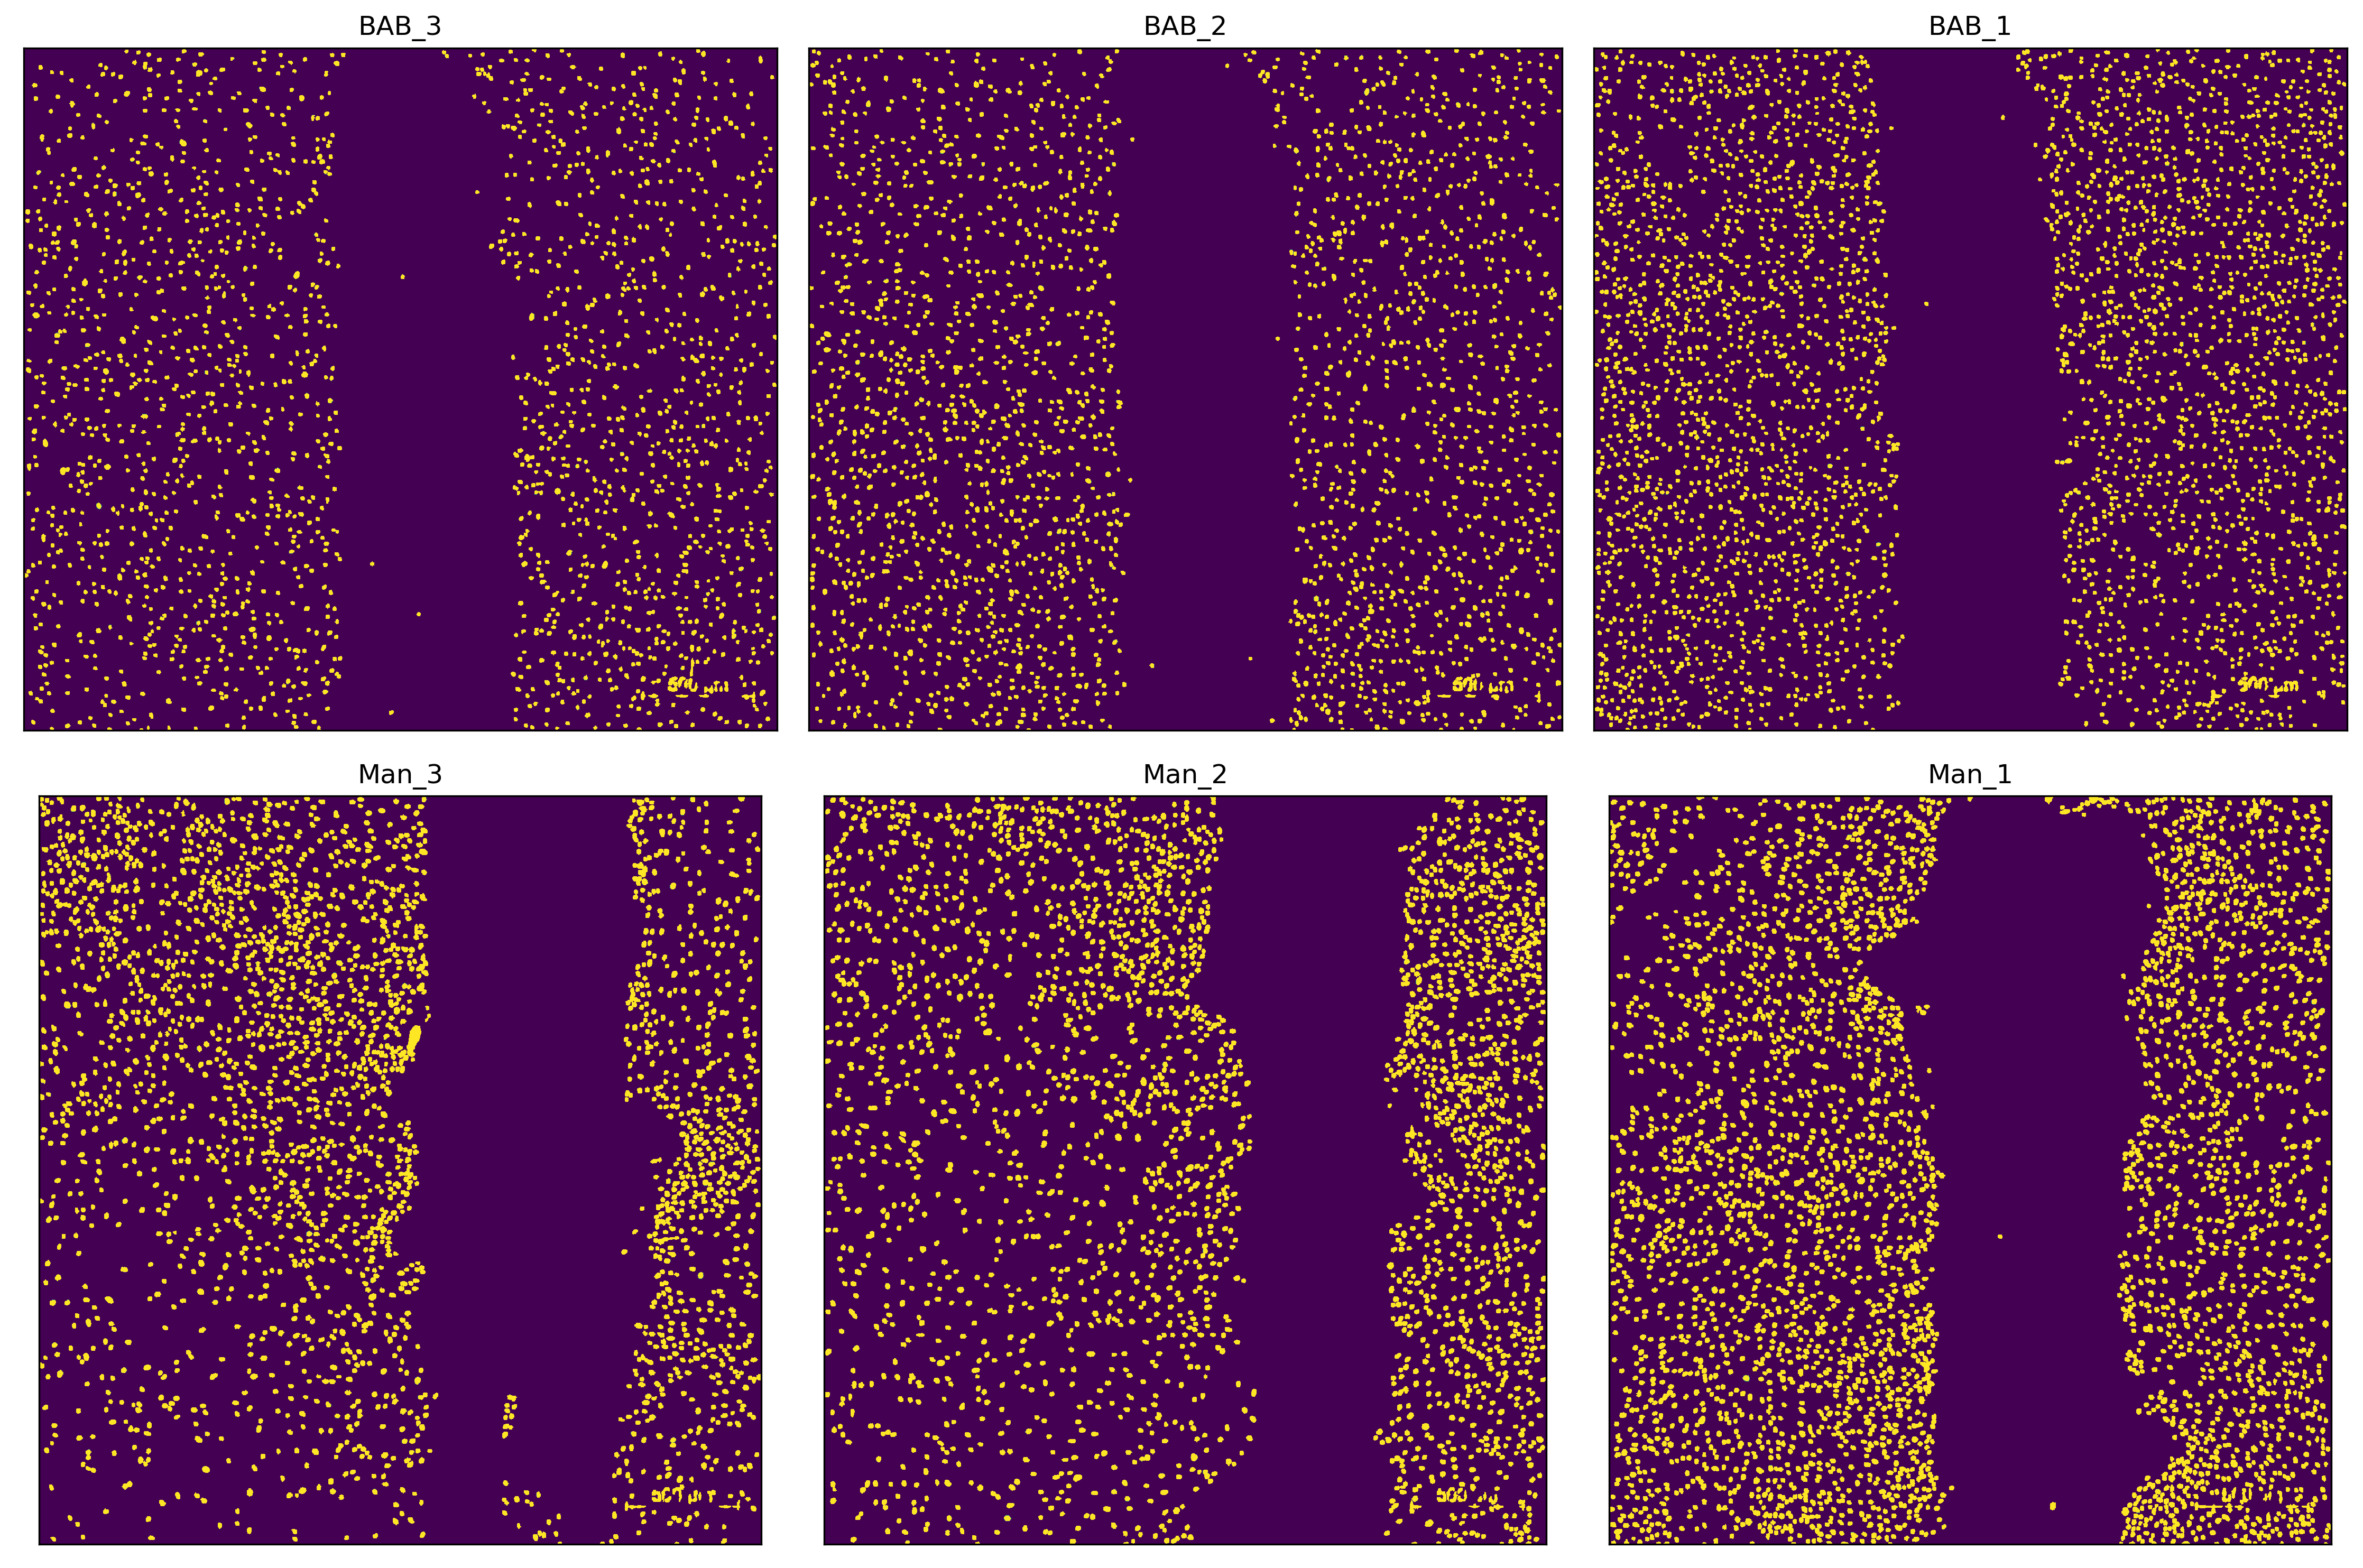

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 10
fig, axs = plt.subplots(2, 3)
axs = axs.ravel()

for i, (label, image) in enumerate(segments.items()):

    axs[i].imshow(image, vmin=0, vmax=1)
    axs[i].set_title(label)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()

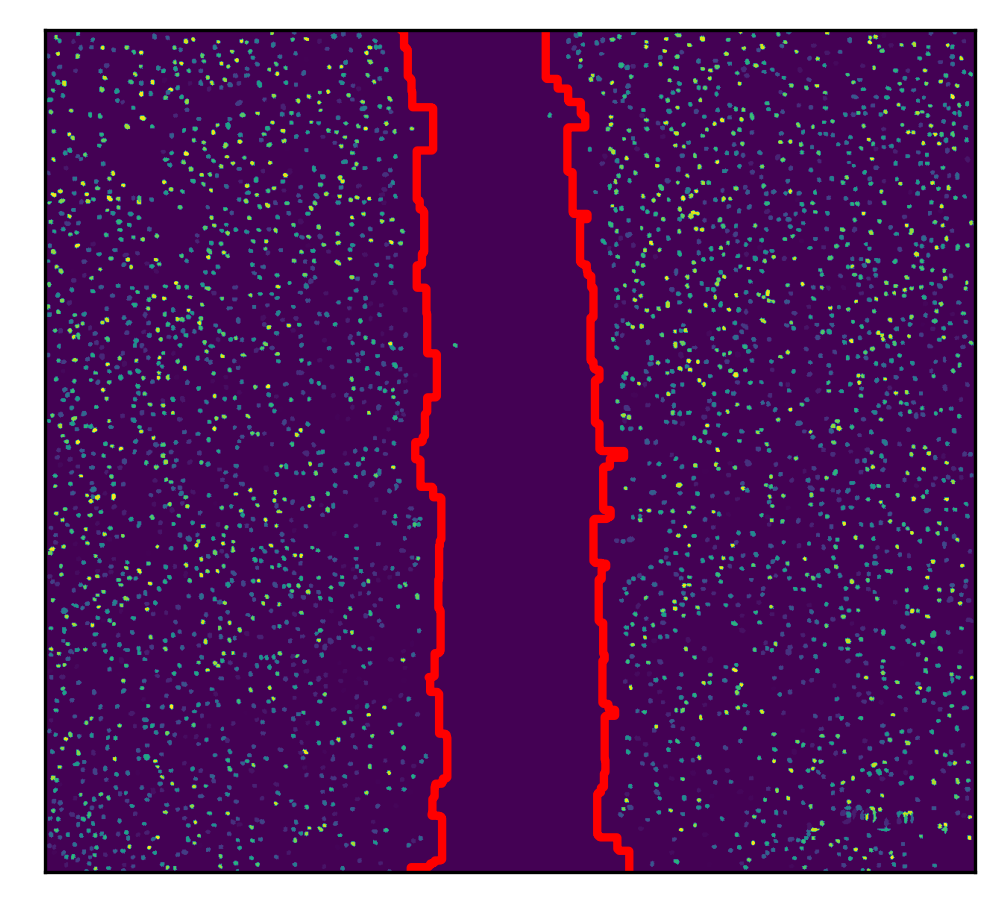

In [5]:
reload(an)

imgId = 'BAB_1' 

img = segments[imgId]
n_img = np.where(img > 0, 1, 0)


# extract the wound
foot = skimage.morphology.square
t = 1
q = 12
dilation = [30, 25]
wound = an.get_wound_area(n_img, 
                          foot, 
                          t=t, # small object
                          q=q, # small hole
                          dilation=dilation)

# plt.imshow(wound)
contours = skimage.measure.find_contours(wound)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
fig, ax = plt.subplots()

ax.imshow(img, cmap="viridis")

ax.set_xticks([])
ax.set_yticks([])

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')

In [6]:
# get all the wounds
foot = skimage.morphology.square
t = 0.5
q = 12
dilation = [25, 30]

wounds = {}
contours = {}

for i, (label, image) in enumerate(segments.items()):
    print(f"Working: {label}...")
    wound = an.get_wound_area(image, 
                              foot, 
                              t=t, # small object
                              q=q, # small hole
                              dilation=dilation)
    wounds[label] = wound

    contour = skimage.measure.find_contours(wound)
    contours[label] = contour

print('done')

Working: BAB_3...
Working: BAB_2...
Working: BAB_1...
Working: Man_3...
Working: Man_2...
Working: Man_1...
done


In [7]:
labels = [
    'BAB_3', 
    'BAB_2', 
    'BAB_1',
    'Man_3', 
    'Man_2', 
    'Man_1'
]

res = []

for label in labels:
    cont = contours[label]
    # loop through the left and right sides of the wound
    # but not the extraneous contours
    for i in [0, 1]:
        tmp = pd.DataFrame(cont[i], columns=['y', 'x'])
        tmp['x_centered'] = tmp['x'] - tmp['x'].mean()
        tmp['y_centered'] = tmp['y'] - tmp['y'].mean()
        tmp['label'] = label
        tmp['edge'] = i
        res.append(tmp)

        print(f"{label=} {i=} {tmp['x_centered'].std()=:.3f}")

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

label='BAB_3' i=0 tmp['x_centered'].std()=9.459
label='BAB_3' i=1 tmp['x_centered'].std()=27.171
label='BAB_2' i=0 tmp['x_centered'].std()=11.077
label='BAB_2' i=1 tmp['x_centered'].std()=28.843
label='BAB_1' i=0 tmp['x_centered'].std()=14.663
label='BAB_1' i=1 tmp['x_centered'].std()=24.133
label='Man_3' i=0 tmp['x_centered'].std()=16.220
label='Man_3' i=1 tmp['x_centered'].std()=25.072
label='Man_2' i=0 tmp['x_centered'].std()=30.423
label='Man_2' i=1 tmp['x_centered'].std()=20.874
label='Man_1' i=0 tmp['x_centered'].std()=30.741
label='Man_1' i=1 tmp['x_centered'].std()=38.526
res.shape=(19072, 6)


,y,x,x_centered,y_centered,label,edge
0,1129.0,516.5,-23.814422,568.990089,BAB_3,0
1,1128.0,516.5,-23.814422,567.990089,BAB_3,0
2,1127.0,516.5,-23.814422,566.990089,BAB_3,0
3,1126.0,516.5,-23.814422,565.990089,BAB_3,0
4,1125.0,516.5,-23.814422,564.990089,BAB_3,0


In [8]:
res['y'].max() / 4

306.5

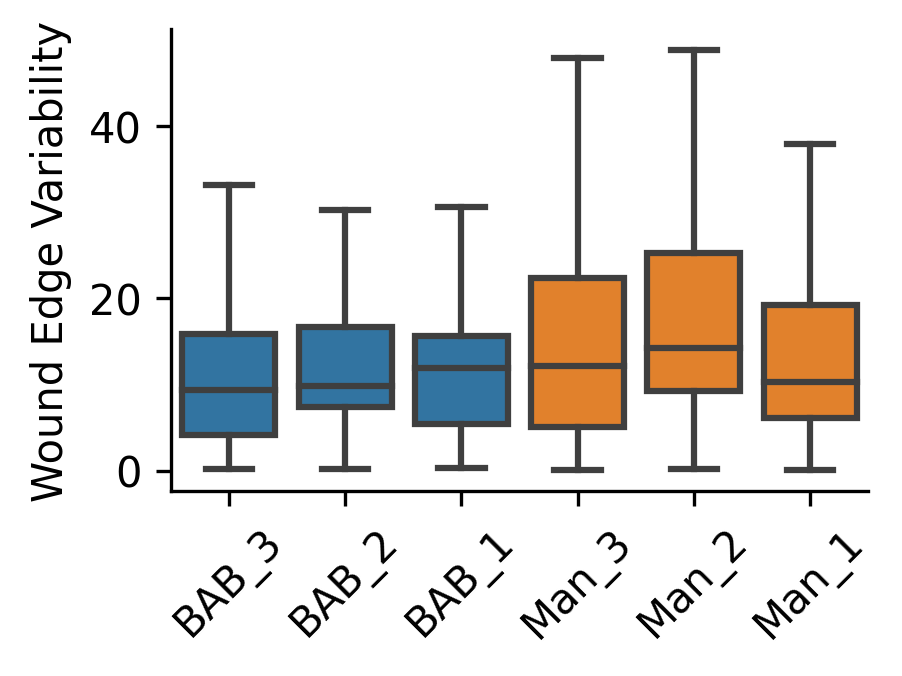

In [12]:
pdf = res.copy()

# include the edges only in the center only
n = 3
ylb = res['y'].max() / 5
yup = res['y'].max() - ylb
pdf = pdf[(pdf['y'] < yup) & (pdf['y'] > ylb)]

pdf['x_var'] = np.abs(pdf['x_centered'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.boxplot(data=pdf, 
              y='x_var',
              x='label',
              hue='label',
              dodge=False,
              showfliers=False,
              palette=['C0', 'C0', 'C0', 'C1', 'C1', 'C1'])

plt.xlabel("")
plt.ylabel("Wound Edge Variability")

sns.despine()
plt.gca().legend().remove()
plt.gca().tick_params(axis='x', rotation=45)

# sns.move_legend(plt.gca(), 
#                 loc='upper left',
#                 bbox_to_anchor=(1.4, 1))

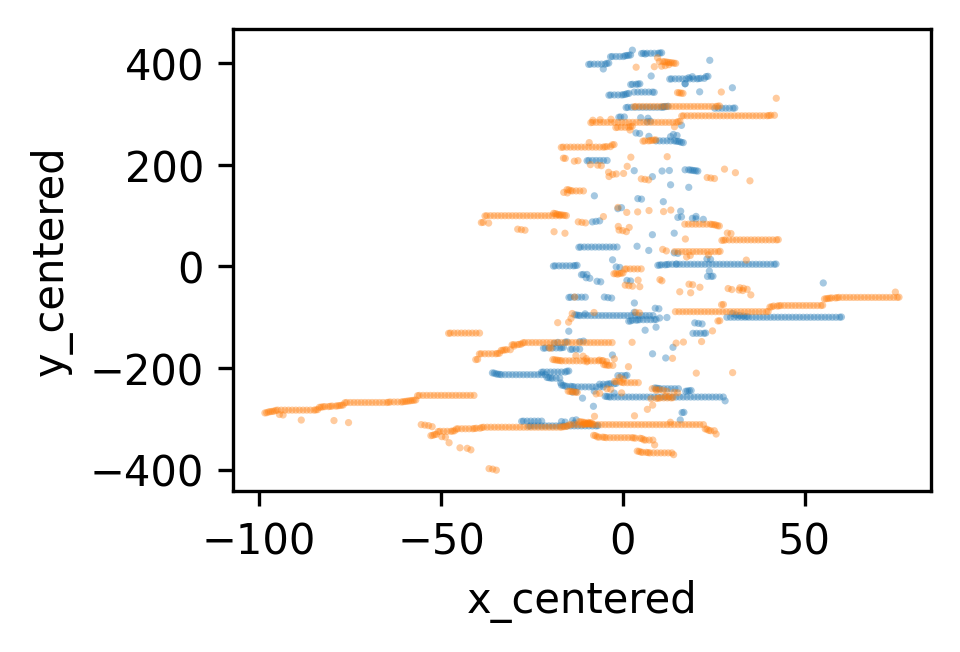

In [13]:
pdf = res.copy()

n = 3
ylb = res['y'].max() / 5
yup = res['y'].max() - ylb
pdf = pdf[(pdf['y'] < yup) & (pdf['y'] > ylb)]

pdf = pdf.drop_duplicates(subset='x_centered')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=pdf, 
              y='y_centered',
              x='x_centered',
              hue='label',
              s=3, 
              alpha=0.4,
              ec='none',
              palette=['C0', 'C0', 'C0', 'C1', 'C1', 'C1'])

# plt.xlabel("")
# plt.ylabel("Wound Edge Variability")

# sns.despine()
plt.gca().legend().remove()
# plt.gca().tick_params(axis='x', rotation=45)

# sns.move_legend(plt.gca(), 
#                 loc='upper left',
#                 bbox_to_anchor=(1.4, 1))